# 1 MLP on Fashion-MNIST
## 1.1 Read the Data

In [1]:
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
from torch.nn import init
from torch.utils.data import DataLoader

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root = "./data/FashionMNIST", train = True, download = True, transform = transforms.ToTensor()) # value between 0 and 1

mnist_test = torchvision.datasets.FashionMNIST(root = "./data/FashionMNIST", train = False, download = True, transform = transforms.ToTensor())

In [3]:
batch_size = 256
train_iter = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

## 1.2 Defining and Initializing the Model


In [4]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return torch.flatten(x,start_dim=1)
class FCNet(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super(FCNet, self).__init__()
        self.fc = nn.Sequential(
            FlattenLayer(),
            nn.Linear(num_inputs, num_hiddens),
            nn.ReLU(),
            nn.Linear(num_hiddens, num_outputs)
        )
    def forward(self, x):
        y = self.fc(x)
        return y

num_inputs, num_outputs, num_hiddens = 784, 10, 256
net = FCNet(num_inputs, num_hiddens, num_outputs)
for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)

## 1.3 Defining the Loss and Optimizer

In [5]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)

## 1.4 Training

In [6]:
def evaluate_accuracy(data_iter):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    return acc_sum / n

num_epochs = 5
for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_l_sum += l
        train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter)
    print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f" % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

epoch 1, loss 0.0031, train acc 0.702, test acc 0.764
epoch 2, loss 0.0019, train acc 0.821, test acc 0.815
epoch 3, loss 0.0017, train acc 0.843, test acc 0.832
epoch 4, loss 0.0015, train acc 0.855, test acc 0.844
epoch 5, loss 0.0014, train acc 0.864, test acc 0.832


# 2 Overfitting & Underfitting on Polynomial Regression

In [7]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt

## 2.1 Generating the Dataset
$$y=1.2x-3.4x^2+5.6x^3+5+\epsilon$$

In [8]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
# Concatenates the given sequence of tensors along the given dimension.
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), dim=1)

labels = poly_features @ torch.tensor(true_w).T + true_b

labels += 0.01 * torch.randn(n_train+n_test)

features[:2], poly_features[:2], labels[:2]


(tensor([[-0.5966],
         [ 0.4678]]),
 tensor([[-0.5966,  0.3559, -0.2123],
         [ 0.4678,  0.2189,  0.1024]]),
 tensor([1.8635, 5.3736]))

## 2.2 Defining the Model

In [9]:
# auxiliary function
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # Make a plot with log scaling on the y axis.
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=":")
        plt.legend(legend)


In [10]:
# Model and train
loss = torch.nn.MSELoss()

def fit_and_plot(num_epochs, train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    batch_size = min(10, train_labels.shape[0])
    dataset = torch.utils.data.TensorDataset(train_features, train_labels) # Construct a dataset for DataLoader
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    # training loss and test loss per epoch
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print("final epoch: train loss ", train_ls[-1], "test loss ", test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls,
            "epochs", "loss",
            range(1, num_epochs + 1), test_ls,
            ["train", "test"])
    print("weight: ", net.weight.data) # omit the attributes like require_grad
    print("bias: ", net.bias.data)


## 2.3 Normal Fitting

final epoch: train loss  0.00010388084774604067 test loss  9.7678042948246e-05
weight:  tensor([[ 1.2021, -3.3999,  5.5991]])
bias:  tensor([5.0012])


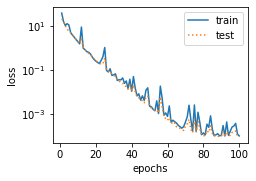

In [11]:
fit_and_plot(num_epochs=100,
            train_features=poly_features[:n_train],
            test_features=poly_features[n_train:], 
            train_labels=labels[:n_train], 
            test_labels=labels[n_train:])

## 2.4 Underfitting
When the features are not sufficient for our regression (our model is too simple)

final epoch: train loss  249.91091918945312 test loss  201.9132080078125
weight:  tensor([[19.4896,  3.9624]])
bias:  tensor([-2.5621])


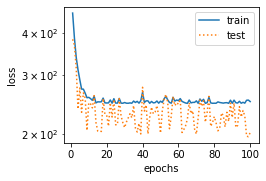

In [12]:
# Both train loss and test loss are high
fit_and_plot(num_epochs=100,
            train_features=poly_features[:n_train, :2],
            test_features=poly_features[n_train:, :2], 
            train_labels=labels[:n_train], 
            test_labels=labels[n_train:])

When we stop too early

final epoch: train loss  7.572160720825195 test loss  7.276164531707764
weight:  tensor([[ 1.6536, -1.9887,  5.3288]])
bias:  tensor([1.6070])


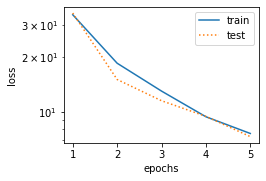

In [13]:
# Only train 5 epochs
fit_and_plot(num_epochs=5,
            train_features=poly_features[:n_train],
            test_features=poly_features[n_train:], 
            train_labels=labels[:n_train], 
            test_labels=labels[n_train:])

## 2.5 Overfitting
When the capacity of training set is not enough

final epoch: train loss  1.248480200767517 test loss  312.0212097167969
weight:  tensor([[1.4676, 0.8344, 0.2206]])
bias:  tensor([2.9799])


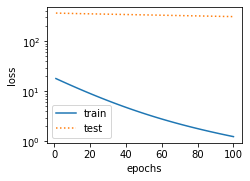

In [14]:
# Only take first 2 instances into account
fit_and_plot(num_epochs=100,
            train_features=poly_features[:2],
            test_features=poly_features[n_train:], 
            train_labels=labels[:2], 
            test_labels=labels[n_train:])

Or when we are using a polynomial of too high degree (see next chapter)

# 3 Weight Decay
prevent overfitting

Features: $\boldsymbol{x}=(x_1,...,x_{200})$

label: $y = 0.05 + \sum_{i=1}^p0.01x_i+\epsilon$

In [15]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# auxiliary function
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # Make a plot with log scaling on the y axis.
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=":")
        plt.legend(legend)

## 3.1 Generating the Dataset

In [17]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05
features = torch.randn(n_train + n_test, num_inputs)
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train], features[n_train:]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [18]:
train_set = torch.utils.data.TensorDataset(train_features, train_labels)
test_set = torch.utils.data.TensorDataset(test_features, test_labels)
batch_size = 1
train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

## 3.2 Defining the Model

In [19]:
num_epochs, lr = 100, 0.003
loss = torch.nn.MSELoss()

def fit_and_plot(wd):
    """
    wd: lambda in weight decay
    """
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls,                    'epochs', 'loss',
              range(1, num_epochs + 1), test_ls,                    ['train', 'test'])
    print("L2 norm of w: ", net.weight.data.norm().item())

L2 norm of w:  12.4380521774292


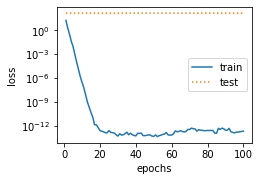

In [20]:
# No weight decay, complex model leads to overfitting
fit_and_plot(0)

L2 norm of w:  0.05972186475992203


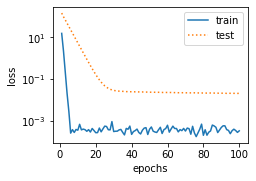

In [21]:
# lambda = 3
fit_and_plot(3)

# 4 Dropout on Fashion-MNIST
prevent overfitting
## 4.1 Hyperparameters

In [22]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np

num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256
drop_prob1, drop_prob2 = 0.2, 0.5
num_epochs, lr, batch_size = 5, 0.5, 256

## 4.2 Reading the Dataset

In [23]:
import torchvision
import torchvision.transforms as transforms

train_set = torchvision.datasets.FashionMNIST(root="./data/FashionMNIST", train=True, transform=transforms.ToTensor(), download=True)

test_set = torchvision.datasets.FashionMNIST(root="./data/FashionMNIST", train=False, transform=transforms.ToTensor(), download=True)

train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

## 4.3 Defining the Model

In [24]:
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.flatten(start_dim=1)

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, 10)
)

for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)

## 4.4 Defining the Loss and Optimizer

In [25]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

## 4.5 Training

In [26]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    return acc_sum / n

for epoch in range(num_epochs):
    train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
    for X, y in train_iter:
        # In Classification problem, we can not use y.view(-1, 1)
        l = loss(net(X), y)
        train_l_sum += l.sum().item()
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        train_acc_sum += (net(X).argmax(dim=1) == y).sum().item()
        n += y.shape[0]
    test_acc = evaluate_accuracy(test_iter, net)
    print("epoch %d, loss %.4f, train acc %.3f, test acc %.3f" % (epoch, train_l_sum / n, train_acc_sum / n, test_acc))


epoch 0, loss 0.0045, train acc 0.576, test acc 0.702
epoch 1, loss 0.0022, train acc 0.810, test acc 0.775
epoch 2, loss 0.0019, train acc 0.842, test acc 0.818
epoch 3, loss 0.0017, train acc 0.860, test acc 0.806
epoch 4, loss 0.0016, train acc 0.870, test acc 0.817


# 5 Predicting House Prices on Kaggle
Dataset can be downloaded from here: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
## 5.1 Reading the Dataset


In [27]:
%matplotlib inline
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

torch.set_default_tensor_type(torch.FloatTensor)

In [28]:
train_data = pd.read_csv("./data/kaggle_house/train.csv")

test_data = pd.read_csv("./data/kaggle_house/test.csv")
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [29]:
train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [30]:
# test_data has no labels (SalePrice)
test_data.iloc[0:4, [0,1,2,3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition
0,1461,20,RH,80.0,WD,Normal
1,1462,20,RL,81.0,WD,Normal
2,1463,60,RL,74.0,WD,Normal
3,1464,60,RL,78.0,WD,Normal


In [31]:
# Id is not important for training
all_features = pd.concat((train_data.iloc[:, 1:], test_data.iloc[:, 1:]))
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


## 5.2 Data Preprocessing

In [32]:
# Standardization/Normalization for numeric features

# index of numeric features
numeric_features = all_features.dtypes[all_features.dtypes != "object"].index

all_features[numeric_features] = all_features[numeric_features].apply(lambda x:((x-x.mean())/x.std()))

# fill Nan with mean(0 after normalization)
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [33]:
# Transform non-numeric features to multiple numeric features
# e.g. There are only 2 different value "RL" and "RM" in column "MSZoning". The new features have 2 new columns "MSZoning_RL" and "MSZoning_RM"
all_features = pd.get_dummies(all_features, dummy_na=True) # Nan will also be seen as a legal value and we'll create a corresponding new column
all_features.shape

(2919, 332)

In [34]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels =torch.tensor(train_data.iloc[:,-1].values, dtype=torch.float).view(-1, 1)

## 5.3 Defining the Model

In [35]:
# Model
def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

We use MSE Loss for training, but the loss we use for Visualization:
$$\sqrt{\frac{1}{n}\sum_{i=1}^n(\log(y_i)-\log(\hat y_i))^2}$$
Note:clipping labels should not be tracked

In [36]:
# Loss
loss = torch.nn.MSELoss()

def log_rmse(net, features, labels):
    
    with torch.no_grad():
        # use 1 when labels are smaller than 1 for numerical stability
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

## 5.4 Training

In [37]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## 5.5 K-fold Validation

In [38]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx, :]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [39]:
import matplotlib.pyplot as plt
# auxiliary function
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    fig = plt.figure(figsize=figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    # Make a plot with log scaling on the y axis.
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=":")
        plt.legend(legend)

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_dacay, batch_size):
    train_l_sum, valid_l_sum = 0.0, 0.0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net(X_train.shape[1])
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, "epochs", "rmse", range(1, num_epochs + 1), valid_ls, ["train", "valid"])
        print("fold %d, train rmse %f, valid rmse %f" % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.159203, valid rmse 0.146526
fold 1, train rmse 0.151394, valid rmse 0.181663
fold 2, train rmse 0.152510, valid rmse 0.155607
fold 3, train rmse 0.157535, valid rmse 0.143834
fold 4, train rmse 0.153619, valid rmse 0.171722
5-fold validation: avg train rmse 0.154852, avg valid rmse 0.159870


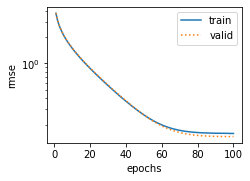

In [40]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

## 5.6 Train and Predict

train rmse 0.150253


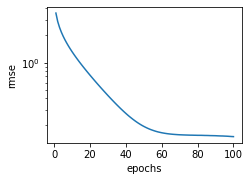

In [41]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('./data/kaggle_house/submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size)